# Autograd: automatic differentiation

The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

In the forward phase, the autograd tape will remember all the operations it executed, and in the backward phase, it will replay the operations.

In [1]:
import torch

Create a tensor:

In [2]:
# Create a 2x2 tensor with gradient-accumulation capabilities
x = torch.tensor([[1, 2], [3, 4]], requires_grad=True, dtype=torch.float32)
print(x)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


 > The param `requires_grad` makes the pytorch keeps record of all the gradiant computations over the tensor

Do an operation on the tensor:

In [3]:
# Deduct 2 from all elements
y = x - 2
print(y)

tensor([[-1.,  0.],
        [ 1.,  2.]], grad_fn=<SubBackward0>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.



In [4]:
print(y.grad_fn)

> SubBackward refers that y was generated from a substraction.

but `x` is directly the same as it was created

In [5]:
# What's happening here?
print(x.grad_fn)

None


> x wasn't modify, it hasn't any gradiant computations

Now, we are going to analyse the gradient information

In [6]:
# Let's dig further...
y.grad_fn

In [7]:
y.grad_fn.next_functions[0][0]

In [8]:
y.grad_fn.next_functions[0][0].variable

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

> We can track to the orginal variable `x` origin of the `y`

Now, we are going to compute a new tensor

In [11]:
# Do more operations on y
z = y * y * 3  # This is the same of 3y^2
a = z.mean()   # average = 1/n * sumi(zi)

print("z = 3y^2 = ")
print(z)

print()
print("a = 1/n * sumi(zi) (where n=2*2=4) =")
print(a)

z = 3y^2 = 
tensor([[ 3.,  0.],
        [ 3., 12.]], grad_fn=<MulBackward0>)

a = 1/n * sumi(zi) (where n=2*2=4) =
tensor(4.5000, grad_fn=<MeanBackward0>)


Represent the gradient computation as a graph

In [12]:
# Let's visualise the computational graph! (thks @szagoruyko)
from torchviz import make_dot

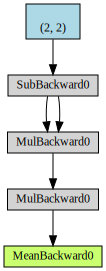

In [13]:
make_dot(a)

We have from top to down:

    1. The original tensor `x` of dimension 2x2
    2. The tensor 'y' generated by the sustraction over `x` 
    3. The y*y operation --> z_1 = y^2
    4. The multiplication by 3 over the previous calculated tensor --> z = 3*z_1
    5. Finally, the mean operation applied over all the values of the previous tensor --> a = 1/4 * sumi(zi)

## Gradients

Let's backprop now `out.backward()` is equivalent to doing `out.backward(torch.tensor([1.0]))`

The manual computation of the gradient of the previous sequence is:

![gradiente computation](./res/gradient_notebook3.png)

Now, we check that the gradient calculated by pytorch is equal to our calculated gradient.

In [14]:
# Backprop
a.backward()

Print gradients $\frac{\text{d}a}{\text{d}x}$.




In [15]:
# Compute it by hand BEFORE executing this
print(x.grad)

tensor([[-1.5000,  0.0000],
        [ 1.5000,  3.0000]])


Perfect! It`s the same gradient value

You can do many crazy things with autograd!
> With Great *Flexibility* Comes Great Responsibility

In [77]:
# Dynamic graphs!
x = torch.randn(3, requires_grad=True)
print(x)

tensor([ 1.8306,  0.3325, -0.7245], requires_grad=True)


In [78]:
y = x * 2
i = 0

#  vertor x norm = sqrt(x1**2 + x2**2 + ... + xn**2)
while y.data.norm() < 1000:
    y = y * 2
    i += 1
print(y)

tensor([ 937.2817,  170.2165, -370.9525], grad_fn=<MulBackward0>)


In [79]:
# If we don't run backward on a scalar we need to specify the grad_output
# gradients = torch.FloatTensor([0.1, 1.0, 0.0001])
gradients = torch.FloatTensor([1.0, 1.0, 1.0])
y.backward(gradients)

print(x.grad)

tensor([512., 512., 512.])


How manys iterations `i` have been executed?

```
y = 2^(i+1) * x

dy/dx = 2^(i+1)
```

In [80]:
import math
math.log2(x.grad[1])-1

8.0

In [81]:
# BEFORE executing this, can you tell what would you expect it to print?
print(i)

8


## Inference

Generate the input and weight matrixes

In [93]:
# This variable decides the tensor's range below
n = 3

In [94]:
# Both x and w that allows gradient accumulation
x = torch.arange(1., n + 1, requires_grad=True)
w = torch.ones(n, requires_grad=True)

print("Generated matrix of input x: ")
print(x)

print()
print("Generated matrix of weights w: ")
print(w)

Generated matrix of input x: 
tensor([1., 2., 3.], requires_grad=True)

Generated matrix of weights w: 
tensor([1., 1., 1.], requires_grad=True)


We do linear regresion

In [95]:
z = w @ x

Now, if we compute gradient

In [96]:
z.backward()

print("Gradient of x :")
print(x.grad)

print()
print("Gradient of w :")
print(w.grad)

Gradient of x :
tensor([1., 1., 1.])

Gradient of w :
tensor([1., 2., 3.])


```
dz/dx = w

dz/dw = x
```

Now, if we repite the same process but we don't allow pytorch to keep traking of gradient computation of `x` input 

In [98]:
# Only w that allows gradient accumulation
x = torch.arange(1., n + 1)
w = torch.ones(n, requires_grad=True)
z = w @ x
z.backward()

print("Gradient of x :")
print(x.grad)

print()
print("Gradient of w :")
print(w.grad)

Gradient of x :
None

Gradient of w :
tensor([1., 2., 3.])


Now, if we compute the linear regression without allow gradient computation (`with torch.no_grad()`) it causes exception when we compute backpropatation.

In [99]:
x = torch.arange(1., n + 1)
w = torch.ones(n, requires_grad=True)

# Regardless of what you do in this context, all torch tensors will not have gradient accumulation
with torch.no_grad():
    z = w @ x

try:
    z.backward()  # PyTorch will throw an error here, since z has no grad accum.
except RuntimeError as e:
    print('RuntimeError!!! >:[')
    print(e)

RuntimeError!!! >:[
element 0 of tensors does not require grad and does not have a grad_fn


## More stuff

Documentation of the automatic differentiation package is at
http://pytorch.org/docs/autograd.